Import some commonly used libraries.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

Finally, some functions that will be helpful for building our model and fitting it.

In [2]:
from scipy.stats import distributions
from scipy.optimize import minimize

# Model some data

Let's say we have a bunch of steel rods made of the same material, with the same diameter.  For each of the rods we measure the length and mass of the rod, which we'll call $l$ and $m$, respectively.

If the manufacturing process were perfect, and our ruler and scale were also perfect, we would expect the relation between $l$ and $m$ to be exactly linear.

In [3]:
n_rods = 100

linear_density = 2.5 # kg/m
lengths = np.random.uniform(1, 10, size=n_rods)
masses = linear_density * lengths

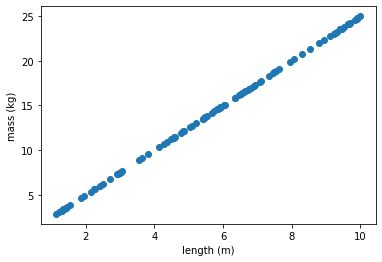

In [4]:
plt.scatter(lengths, masses)
plt.xlabel('length (m)')
plt.ylabel('mass (kg)');

In [5]:
data = np.column_stack([lengths, masses])

# Construct a model

Without any manufacturing or measurement noise, we can model the data perfectly with a linear model.

$$
m = \alpha l + \beta,
$$

where $\alpha$ is the slope of the line and $\beta$ is the $y$-intercept.

In [6]:
def build_linear_model(slope, intercept):
    def linear_model(length):
        return length * slope + intercept
    return linear_model

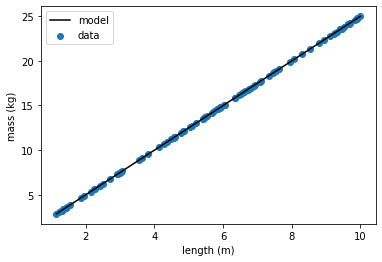

In [7]:
xmin = min(lengths)
xmax = max(lengths)

xs = np.linspace(xmin, xmax, 50)
model = build_linear_model(linear_density, 0)

plt.scatter(lengths, masses, label='data')
plt.plot(xs, model(xs), label='model', color='k')
plt.xlabel('length (m)')
plt.ylabel('mass (kg)')
plt.legend(loc='upper left');

## Add some realism

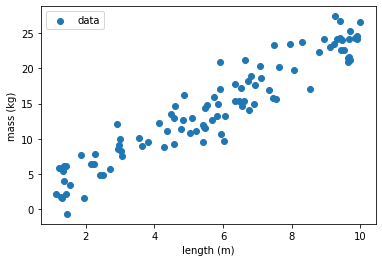

In [8]:
sigma = 2.
masses += np.random.normal(scale=sigma, size=len(masses))

plt.scatter(lengths, masses, label='data')
plt.xlabel('length (m)')
plt.ylabel('mass (kg)')
plt.legend(loc='upper left');

Let's say that we have some robust measuring techniques, and the measurement uncertainties are neglible.  This means there must be some "noise" in the manufacturing techniques.  Maybe the density of the steel varies, maybe the diameter does.  Let's see how bad the manufacturer is.

We need to add a noise term to our model.  Lets model the noise introduced during manufactoring as being Gaussian.

$$
m = \alpha l + \beta + N,
$$

where $N\sim N(0, \sigma)$.  Here, $\alpha$, $\beta$, and $l$ are just numbers, but $N$ is a _random variable_.  It respresents some random process that can have a different numerical value each time you observe it.  All that we can say about that process is that after many draws, we expect the distibution of values to follow a normal distribution with a mean of $0$ and standard deviation $\sigma$.

The process of linear regression can now be phrased in terms of _likelihood_.  The question is, if we've properly modeled the non-random linear part of the data ($\alpha l + \beta$), how _likely_ is it that whats left (the residuals) could have come from the $N(0, \sigma)$ distribution?

Recall the normal distribution:
$$
f(x|\mu, \Sigma) = \frac{1}{\sqrt{2\pi\Sigma^2}}\exp \left(-\frac{(x-\mu)^2}{2\Sigma^2}\right)
$$

So that means our likelihood is:
$$
\mathcal{L}(\alpha, \beta, \sigma) = p(\{m_i\}|\alpha, \beta, \sigma) = \prod_i f(r_i|\mu=0, \Sigma=\sigma)),
$$
where $r_i = m_i - (\alpha l + \beta)$ are the residuals.

In [9]:
def lnlikelihood(model_params, xs=lengths):
    # Unpack the model variables
    slope, intercept, sigma_noise = model_params
    
    # Build the linear (i.e., "signal") portion of the model
    linear_model = build_linear_model(slope, intercept)
    
    # Subtract the model from the data, leaving just the "noise" if we've done a proper fit
    residuals = masses - linear_model(xs)
    
    # Assess how consistent the residuals are with our model for the noise (normal)
    lnlike = np.sum(distributions.norm.logpdf(residuals, loc=0, scale=sigma_noise))
    return lnlike

## Find the best fit

Let's find the values for $\alpha$, $\beta$, and $\sigma$ that maximize the likelihood.  These can be thought of as the _best fit_ parameters.

We will use [Powell's method](https://en.wikipedia.org/wiki/Powell%27s_method) to find the point that maximizes the likelihood, but first we need an initial guess to start from. 

In [10]:
params0 = [2, 0, .2]

sol = minimize(lambda params: -lnlikelihood(params), params0, method='powell')
best_fit_params = sol.x

..and take a look at our best fit.

Best fit slope of 2.442 kg/m


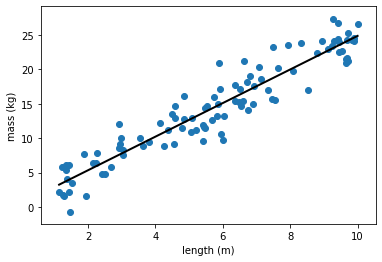

In [11]:
best_fit_model = build_linear_model(best_fit_params[0], best_fit_params[1])

xs = np.linspace(xmin, xmax, 50)

plt.plot(xs, best_fit_model(xs), color='k', lw=2)
plt.scatter(lengths, masses)
plt.xlabel('length (m)')
plt.ylabel('mass (kg)')

print("Best fit slope of {:.3f} kg/m".format(best_fit_params[0]))

Let's subtract our best guess and the underlying linear component to the data to see what the noise looks like.

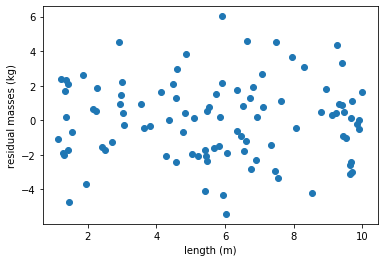

In [12]:
residuals = masses - best_fit_model(lengths)
plt.scatter(lengths, residuals)
plt.ylabel('residual masses (kg)')
plt.xlabel('length (m)');

Since we expect them to follow a normal distribution, lets look at their histogram and compare it to a normal distribution with 0 mean and a standard deviation corresponding to our best fit $\sigma$.

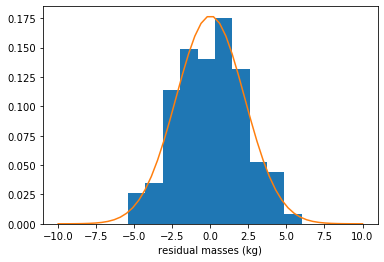

In [13]:
xs = np.linspace(-10, 10, 50)

plt.hist(residuals, bins=10, density=True);
plt.plot(xs, distributions.norm.pdf(xs, scale=best_fit_params[2]))
plt.xlabel('residual masses (kg)');

The residuals look pretty Guassian, giving us some confidence that our modeling of the manufacturing "noise" is appropriate.